In [1]:
from sklearn import metrics
import numpy as np
import pandas as pd
import datetime
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
#########SKLearn 集成的算法###############
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB
#########SKLearn 集成的算法###############
from sklearn.model_selection import train_test_split # 切分数据
from sklearn.metrics import mean_squared_error #评价指标

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [8]:
############全局参数#################################
id_col_names=['user_id','coupon_id','date_received']
target_col_name='label'
id_target_cols=['user_id','coupon_id','date_received','label']
myeval='roc_auc'
cvscore=0
############目录定义#################################
datapath = 'data/'
featurepath = 'data/feature/'
resultpath = 'data/result/'
tmppath = 'data/tmp/'
scorepath = 'data/score/'
###########工具函数#############################################

In [3]:
###########工具函数#############################################
#返回ID列
def get_id_df(df):
    return df[id_col_names]

#返回Target列
def get_target_df(df):
    return df[target_col_name]

#返回特征列
def get_predictors_df(df):
    predictors = [f for f in df.columns if f not in id_target_cols]
    return df[predictors]

#按特征名读取训练集
def read_featurefile_train(featurename):
    df=pd.read_csv(featurepath+'train_'+featurename+'.csv', sep=',' , encoding = "utf-8")
    df.fillna(0,inplace=True)
    return df

#按特征名读取测试集
def read_featurefile_test(featurename):
    df=pd.read_csv(featurepath+'test_'+featurename+'.csv', sep=',' , encoding = "utf-8")
    df.fillna(0,inplace=True)
    return df

#按特征名读取数据
def read_data(featurename):
    traindf = read_featurefile_train(featurename)
    testdf = read_featurefile_test(featurename)
    return traindf,testdf

In [4]:
###########工具函数#############################################
#返回ID列
def get_id_df(df):
    return df[id_col_names]

#返回Target列
def get_target_df(df):
    return df[target_col_name]

#返回特征列
def get_predictors_df(df):
    predictors = [f for f in df.columns if f not in id_target_cols]
    return df[predictors]

#按特征名读取训练集
def read_featurefile_train(featurename):
    df=pd.read_csv(featurepath+'train_'+featurename+'.csv', sep=',' , encoding = "utf-8")
    df.fillna(0,inplace=True)
    return df

#按特征名读取测试集
def read_featurefile_test(featurename):
    df=pd.read_csv(featurepath+'test_'+featurename+'.csv', sep=',' , encoding = "utf-8")
    df.fillna(0,inplace=True)
    return df

#按特征名读取数据
def read_data(featurename):
    traindf = read_featurefile_train(featurename)
    testdf = read_featurefile_test(featurename)
    return traindf,testdf

In [5]:
# 将特征归一化
def standize_df(train_data,test_data):
    from sklearn import preprocessing

    features_columns = [f for f in test_data.columns if f not in id_target_cols]
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler = min_max_scaler.fit(train_data[features_columns])

    train_data_scaler = min_max_scaler.transform(train_data[features_columns])
    test_data_scaler = min_max_scaler.transform(test_data[features_columns])

    train_data_scaler = pd.DataFrame(train_data_scaler)
    train_data_scaler.columns = features_columns

    test_data_scaler = pd.DataFrame(test_data_scaler)
    test_data_scaler.columns = features_columns

    train_data_scaler['label'] = train_data['label']
    train_data_scaler[id_col_names] = train_data[id_col_names]
    test_data_scaler[id_col_names] = test_data[id_col_names]
    return train_data_scaler,test_data_scaler

In [6]:
####################部分整合在sklearn的分类算法###############
def get_sklearn_model(model_name):
    #朴素贝叶斯
    if model_name=='NB':
        return MultinomialNB(alpha=0.01)
    #逻辑回归
    elif model_name=='LR':
        return LogisticRegression(penalty='l2')
    # KNN
    elif model_name=='KNN':
        return KNeighborsClassifier()
    #随机森林
    elif model_name=='RF':
        return RandomForestClassifier()
    #决策树
    elif model_name=='DT':
        return tree.DecisionTreeClassifier()
    #向量机
    elif model_name=='SVC':
        return SVC(kernel='rbf')
    #GBDT
    elif model_name=='GBDT':
        return GradientBoostingClassifier()
    #XGBoost
    elif model_name=='XGB':
        return XGBClassifier()
    #lightGBM
    elif model_name=='LGB':
        return LGBMClassifier()
    else:
        print("wrong model name!")


#画学习曲线
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=[0.01,0.02,0.05,0.1,0.2,0.3]):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv,scoring=myeval, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#画算法的学习曲线,为加快画图速度，最多选20%数据
def plot_curve_single(traindf,classifier,cvnum,train_sizes=[0.01,0.02,0.05,0.1,0.2,0.3]):
    X=get_predictors_df(traindf)
    y=get_target_df(traindf)
    estimator = get_sklearn_model(classifier)    #建模
    title = "learning curve of "+classifier+", cv:"+str(cvnum)
    plot_learning_curve(estimator, title, X, y, ylim=(0, 1.01), cv=cvnum, train_sizes=train_sizes)


#性能评价函数
#本赛题目标是预测投放的优惠券是否核销。
#针对此任务及一些相关背景知识，使用优惠券核销预测的平均AUC（ROC曲线下面积）作为评价标准。
#即对每个优惠券coupon_id单独计算核销预测的AUC值，再对所有优惠券的AUC值求平均作为最终的评价标准。
# coupon平均auc计算
def myauc(test):
    testgroup = test.groupby(['coupon_id'])
    aucs = []
    for i in testgroup:
        coupon_df = i[1]
        #测算AUC必须大于1个类别
        if len(coupon_df['label'].unique()) < 2:
            continue
        auc = metrics.roc_auc_score(coupon_df['label'], coupon_df['pred'])
        aucs.append(auc)
    return np.average(aucs)

#按照日期分割
def test_model(traindf,classifier):
    train=traindf[traindf.date_received<20160515].copy()
    test=traindf[traindf.date_received>=20160515].copy()

    train_data = get_predictors_df(train).copy()
    train_target = get_target_df(train).copy()
    test_data = get_predictors_df(test).copy()
    test_target = get_target_df(test).copy()

    clf = get_sklearn_model(classifier)
    clf.fit(train_data, train_target)
    result=clf.predict_proba(test_data)[:,1]
    test['pred']=result
    score = metrics.roc_auc_score(test_target, result)
    print(classifier+" 总体 AUC:", score)
    score_coupon = myauc(test)
    print(classifier+" Coupon AUC:", score_coupon)


def test_model_split(traindf,classifier):

    target = get_target_df(traindf).copy()

    train_all,test_all,train_target,test_target=train_test_split(traindf,target,test_size=0.2,random_state=0)

    train_data = get_predictors_df(train_all).copy()
    test_data = get_predictors_df(test_all).copy()

    clf = get_sklearn_model(classifier)
    clf.fit(train_data, train_target)
    result=clf.predict_proba(test_data)[:,1]

    test=test_all.copy()
    test['pred']=result

    score = metrics.roc_auc_score(test_target, result)
    print(classifier+"总体AUC:", score)
    score_coupon = myauc(test)
    print(classifier+" Coupon AUC:", score_coupon)

In [9]:
#所有的特征都是上一节生成的
train_f1,test_f1=read_data('f1')
#因为要使用KNN等进行测试，所以需要归一化
train_f1,test_f1=standize_df(train_f1,test_f1)

LR 总体 AUC: 0.6653536857862119
LR Coupon AUC: 0.5381247642711647
LR Coupon AUC


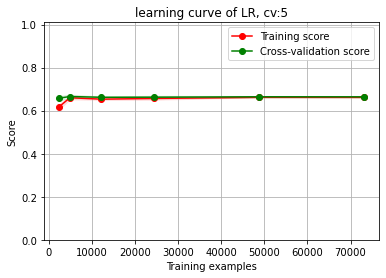

In [10]:
test_model(train_f1,'LR')
print('LR Coupon AUC')
plot_curve_single(train_f1,'LR',5,[0.01,0.02,0.05,0.1,0.2,0.3])

NB 总体 AUC: 0.6670944091690476
NB Coupon AUC: 0.5381247642711647


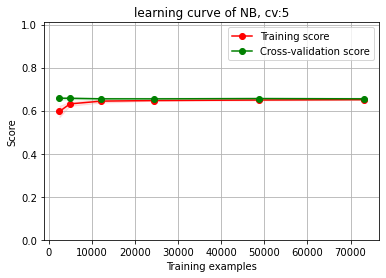

In [11]:
test_model(train_f1,'NB')
plot_curve_single(train_f1,'NB',5,[0.01,0.02,0.05,0.1,0.2,0.3])

DT 总体 AUC: 0.6481607651168957
DT Coupon AUC: 0.5302514392404754


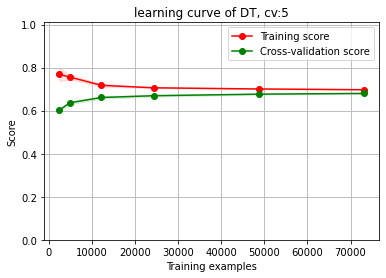

In [12]:
test_model(train_f1,'DT')
plot_curve_single(train_f1,'DT',5,[0.01,0.02,0.05,0.1,0.2,0.3])

RF 总体 AUC: 0.6473478317686718
RF Coupon AUC: 0.5304415492121641


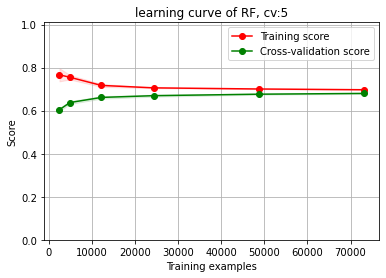

In [13]:
test_model(train_f1,'RF')
plot_curve_single(train_f1,'RF',5,[0.01,0.02,0.05,0.1,0.2,0.3])

LGB 总体 AUC: 0.6534077718076291
LGB Coupon AUC: 0.5327884933599097


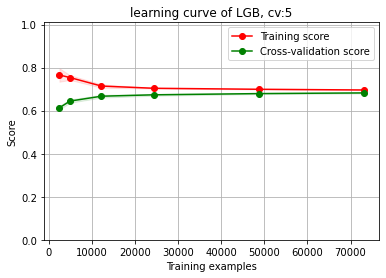

In [14]:
test_model(train_f1,'LGB')
plot_curve_single(train_f1,'LGB',5,[0.01,0.02,0.05,0.1,0.2,0.3])

[16:24:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB 总体 AUC: 0.6537138075207527
XGB Coupon AUC: 0.531849037296699
[16:24:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss

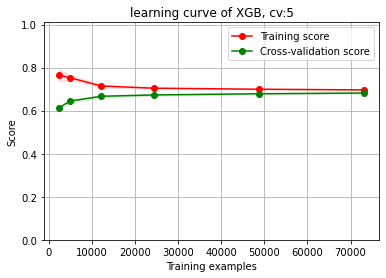

In [15]:
test_model(train_f1,'XGB')
plot_curve_single(train_f1,'XGB',5,[0.01,0.02,0.05,0.1,0.2,0.3])

In [16]:
#所有的特征都是上一节生成的
train_f2,test_f2=read_data('sf2')
#因为要使用KNN等进行测试，所以需要归一化
train_f2,test_f2=standize_df(train_f2,test_f2)

#所有的特征都是上一节生成的
train_f3,test_f3=read_data('sf3')
#因为要使用KNN等进行测试，所以需要归一化
train_f3,test_f3=standize_df(train_f3,test_f3)

In [17]:
print('特征f1逻辑回归成绩')
test_model(train_f1,'LR')
print('特征sf2逻辑回归成绩')
test_model(train_f2,'LR')
print('特征sf3逻辑回归成绩')
test_model(train_f3,'LR')

特征f1逻辑回归成绩
LR 总体 AUC: 0.6653536857862119
LR Coupon AUC: 0.5381247642711647
特征sf2逻辑回归成绩
LR 总体 AUC: 0.7603243479272986
LR Coupon AUC: 0.6029319950841423
特征sf3逻辑回归成绩
LR 总体 AUC: 0.8100281680479542
LR Coupon AUC: 0.7290111292220179


In [18]:
#预测函数
def classifier_df_simple(train_feat, test_feat,classifier):
    model = get_sklearn_model(classifier)
    model.fit(get_predictors_df(train_feat), get_target_df(train_feat))
    predicted = pd.DataFrame(model.predict_proba(get_predictors_df(test_feat))[:,1])
    return predicted
#输出结果函数
def output_predicted(predicted,resultfile,test_feat):
    predicted=round(predicted,3)
    resultdf=get_id_df(test_feat).copy()
    resultdf['Probability']=predicted
    return resultdf

In [19]:
predicted=classifier_df_simple(train_f3, test_f3,'LGB')

In [20]:
predicted.head()

,0
0,0.007423
1,0.132002
2,0.006900
3,0.012854
4,0.035856


In [21]:
result=output_predicted(predicted,'sf3_LGB.csv',test_f3)

In [22]:
result.head()

,user_id,coupon_id,date_received,Probability
0,4129537,9983,20160712,0.007
1,6949378,3429,20160706,0.132
2,2166529,6928,20160727,0.007
3,2166529,1808,20160727,0.013
4,6172162,6500,20160708,0.036


In [23]:
#输出结果
result.to_csv('sf3_lgb.csv',header=False,index=False,sep=',')